In [1]:
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
pred_model = pd.read_csv("Pred_Model.csv")

In [3]:
pred_model['start_time'] = pd.to_datetime(pred_model['start_time'])
pred_model['end_time'] = pd.to_datetime(pred_model['end_time'])

In [4]:
pred_model_counts = pred_model.groupby([pd.Grouper(key='start_time', freq = 'H')]).size().to_frame('counts')

In [5]:
pred_model_counts["counts"].sum()

1235121

In [6]:
# make index to column to create day of week and month based on date
pred_model_counts['index1'] = pred_model_counts.index
pred_model_counts["hourofday"] = pred_model_counts["index1"].dt.hour
pred_model_counts["weekday"] = pred_model_counts["index1"].dt.dayofweek
pred_model_counts["month"] = pred_model_counts["index1"].dt.month

In [7]:
pred_model_counts = pred_model_counts.drop('index1', axis=1)

In [8]:
pred_model_counts.index.names = ['daytime']
pred_model_counts.index = pd.to_datetime(pred_model_counts.index)
pred_model_counts

,counts,hourofday,weekday,month
daytime,,,,
2016-01-01 00:00:00,13,0,4,1
2016-01-01 01:00:00,14,1,4,1
2016-01-01 02:00:00,9,2,4,1
2016-01-01 03:00:00,1,3,4,1
2016-01-01 04:00:00,0,4,4,1
...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12
2016-12-31 20:00:00,13,20,5,12
2016-12-31 21:00:00,22,21,5,12


## Import weather and merge with pred_model_counts

In [9]:
weather_hourly = pd.read_csv('weather_hourly.csv')
weather_hourly.head()

,Unnamed: 0,max_temp,min_temp,precip,interp_maxtemp,interp_mintemp,interp_precip,update_maxtemp,update_mintemp,update_precip
0,2015-01-01 06:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
1,2015-01-01 07:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
2,2015-01-01 08:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
3,2015-01-01 09:00:00,-4.4,-4.4,0.0,-4.4,-4.4,0.0,-4.4,-4.4,0.0
4,2015-01-01 10:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0


In [10]:
weatherhour = weather_hourly.drop(columns = ['max_temp','min_temp','precip','interp_maxtemp','interp_mintemp','interp_precip'])
weatherhour['temp_av'] = (weatherhour['update_maxtemp'] + weatherhour['update_mintemp']) / 2
weatherhour = weatherhour.drop(columns = ['update_mintemp', 'update_maxtemp'])
weatherhour = weatherhour.set_index('Unnamed: 0')
weatherhour.index.names = ['daytime']
weatherhour.index = pd.to_datetime(weatherhour.index)
weatherhour

,update_precip,temp_av
daytime,,
2015-01-01 06:00:00,0.0,-5.6
2015-01-01 07:00:00,0.0,-5.6
2015-01-01 08:00:00,0.0,-5.6
2015-01-01 09:00:00,0.0,-4.4
2015-01-01 10:00:00,0.0,-5.6
...,...,...
2020-01-02 01:00:00,0.0,3.3
2020-01-02 02:00:00,0.0,3.3
2020-01-02 03:00:00,0.0,2.8


In [11]:
weatherhour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2015-01-01 06:00:00 to 2020-01-02 05:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   update_precip  43848 non-null  float64
 1   temp_av        43848 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [12]:
weatherhour = weatherhour.loc['2016-01-01 00:00:00' : '2017-01-01 00:00:00']
weatherhour

,update_precip,temp_av
daytime,,
2016-01-01 00:00:00,0.0,5.6
2016-01-01 01:00:00,0.0,5.0
2016-01-01 02:00:00,0.0,5.0
2016-01-01 03:00:00,0.0,4.4
2016-01-01 04:00:00,0.0,4.4
...,...,...
2016-12-31 20:00:00,0.0,1.7
2016-12-31 21:00:00,0.0,1.7
2016-12-31 22:00:00,0.0,2.2


In [13]:
pred_model_joint = pred_model_counts.join(weatherhour, how="left")
pred_model_joint

,counts,hourofday,weekday,month,update_precip,temp_av
daytime,,,,,,
2016-01-01 00:00:00,13,0,4,1,0.0,5.6
2016-01-01 01:00:00,14,1,4,1,0.0,5.0
2016-01-01 02:00:00,9,2,4,1,0.0,5.0
2016-01-01 03:00:00,1,3,4,1,0.0,4.4
2016-01-01 04:00:00,0,4,4,1,0.0,4.4
...,...,...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12,0.0,1.7
2016-12-31 20:00:00,13,20,5,12,0.0,1.7
2016-12-31 21:00:00,22,21,5,12,0.0,1.7


Variables

- Time of the day in hours 
- Month
- Weekday (0-6)
- Temperature (average of min and max temp cause very similar)
- Precipitation (0,1)

In [14]:
from sklearn.model_selection import train_test_split

# Extract the relevant features from the dataset
X = pred_model_joint[['hourofday', 'weekday', 'month', 'update_precip', 'temp_av']]
y = pred_model_joint['counts']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from scipy import stats

# Calculate the means of both training and test set for each value
train_mean = X_train.mean()
test_mean = X_test.mean()

# create a table for comparing the means
mean_table = pd.concat([train_mean, test_mean], axis=1)
mean_table.columns = ['Train Mean', 'Test Mean']

# Perform t-test
t, p = stats.ttest_ind(X_train, X_test, equal_var=False)

# Add p-values to the table
mean_table['p-value'] = p

#Print the table
print(mean_table)

# the p-values are greater than 0.05, which means that there is
# no significant difference between the means of the training and test datasets. 

               Train Mean  Test Mean   p-value
hourofday       11.463640  11.645418  0.326012
weekday          3.018927   2.965282  0.309641
month            6.527537   6.458167  0.453081
update_precip    0.080618   0.069437  0.095668
temp_av         11.746625  11.575949  0.516439


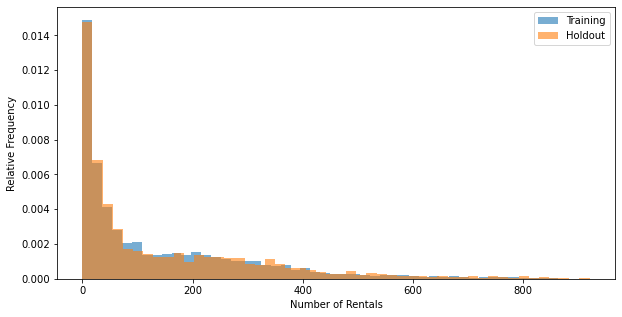

In [16]:
# Plot the distribution of the target variable in the training and holdout sets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.6, label='Training', density= True)
plt.hist(y_test, bins=50, alpha=0.6, label='Holdout', density= True)
plt.xlabel('Number of Rentals')
plt.ylabel('Relative Frequency')
plt.legend()
plt.show()

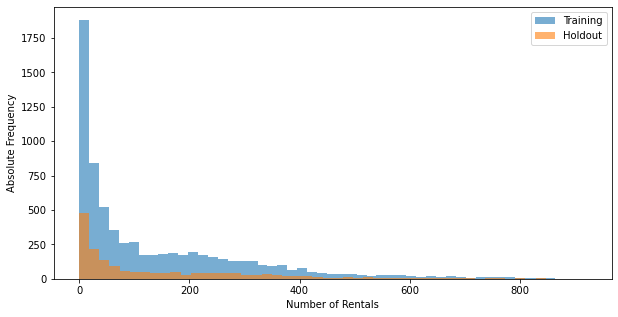

In [17]:
# Plot the distribution of the target variable in the training and holdout sets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.6, label='Training')
plt.hist(y_test, bins=50, alpha=0.6, label='Holdout')
plt.xlabel('Number of Rentals')
plt.ylabel('Absolute Frequency')
plt.legend()
plt.show()

## 4. Linear/Polynomial Regression

In [22]:
#### To Create Dummys, we need to convert variables to "category" type
X_train['weekday']=X_train['weekday'].astype('category')
X_train['month']=X_train['month'].astype('category')
X_train['update_precip']=X_train['update_precip'].astype('category')
X_train['hourofday']=X_train['hourofday'].astype('category')
X_train = pd.get_dummies(X_train, drop_first=True)
X_train.head()

C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/89998143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['weekday']=X_train['weekday'].astype('category')
C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/89998143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month']=X_train['month'].astype('category')
C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/89998143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,temp_av,hourofday_1,hourofday_2,hourofday_3,hourofday_4,hourofday_5,hourofday_6,hourofday_7,hourofday_8,hourofday_9,...,month_7,month_8,month_9,month_10,month_11,month_12,update_precip_0.3333333333333333,update_precip_0.5,update_precip_0.6666666666666666,update_precip_1.0
daytime,,,,,,,,,,,,,,,,,,,,,
2016-09-20 03:00:00,21.10,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2016-04-13 12:00:00,5.60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-07 23:00:00,2.20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-08-25 12:00:00,22.20,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-01-16 07:00:00,5.45,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
X_test['weekday']=X_test['weekday'].astype('category')
X_test['month']=X_test['month'].astype('category')
X_test['update_precip']=X_test['update_precip'].astype('category')
X_test['hourofday']=X_test['hourofday'].astype('category')
X_test = pd.get_dummies(X_test, drop_first=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1757 entries, 2016-09-23 01:00:00 to 2016-07-01 14:00:00
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   temp_av                           1757 non-null   float64
 1   hourofday_1                       1757 non-null   uint8  
 2   hourofday_2                       1757 non-null   uint8  
 3   hourofday_3                       1757 non-null   uint8  
 4   hourofday_4                       1757 non-null   uint8  
 5   hourofday_5                       1757 non-null   uint8  
 6   hourofday_6                       1757 non-null   uint8  
 7   hourofday_7                       1757 non-null   uint8  
 8   hourofday_8                       1757 non-null   uint8  
 9   hourofday_9                       1757 non-null   uint8  
 10  hourofday_10                      1757 non-null   uint8  
 11  hourofday_11                     

C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/3117573012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['weekday']=X_test['weekday'].astype('category')
C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/3117573012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month']=X_test['month'].astype('category')
C:\Users\lucas\AppData\Local\Temp/ipykernel_8156/3117573012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

### Polynomial Regression degree = 1 

In [24]:
poly = PolynomialFeatures(degree=1)

In [25]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [26]:
reg = LinearRegression(fit_intercept=True).fit(X_train_poly, y_train)

In [27]:
y_pred = reg.predict(X_test_poly)

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

Mean Squared Error:  9893.715539336848
Mean Absolute Error:  74.51248927233152
R-squared:  0.6698756567446307


In [89]:
coef_names = poly.get_feature_names_out()
coef_dict = dict(zip(coef_names, reg.coef_))

coef_df = pd.DataFrame(list(coef_dict.items()), columns=["Feature Name", "Coefficient"])
coef_df.loc['Intercept'] = reg.intercept_

# Display the coefficients with five decimal places instead of scientific notation (for visualization purposes only)
coef_df["Coefficient"] = coef_df["Coefficient"].apply(lambda x: "{:.5f}".format(x))

coef_df

,Feature Name,Coefficient
0,1,-0.00000
1,temp_av,3.17932
2,hourofday_1,-7.14753
3,hourofday_2,-8.58092
4,hourofday_3,-16.38911
5,hourofday_4,-15.75805
6,hourofday_5,0.06226
7,hourofday_6,54.80925
8,hourofday_7,165.93757
9,hourofday_8,289.71710


In this table, you can see the coefficients that have been calculated by the linear regression model in order to predict the target variable (the number of rentals per hour). The coefficient indicates how strongly the feature affects the prediction. A positive coefficient means that the feature has a positive correlation with the target variable, i.e. the higher the feature, the higher the prediction. A negative coefficient means the opposite. It can be seen that, for example, temperature has a positive influence (coefficient of 3.17932). As precipitation increases, the coefficient values become more negative, indicating a negative correlation with the target variable.
The final value, called "Intercept," gives the value of the model when all features are 0. In this case, it is -89.63690.

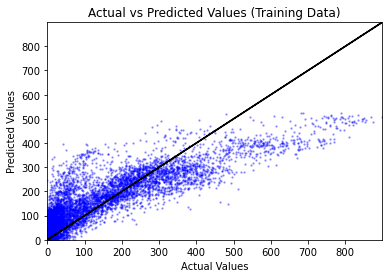

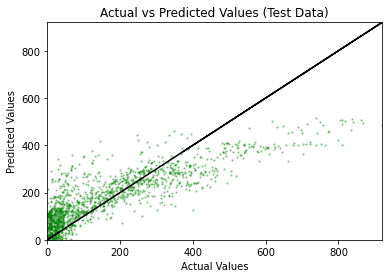

In [90]:
# Use the model to predict the target variable for the training data
predicted_values_train = reg.predict(X_train_poly)

# Use the model to predict the target variable for the test data
predicted_values_test = reg.predict(X_test_poly)

# Plot the actual target values against the predicted values for the training data
plt.scatter(y_train, predicted_values_train, color = "blue", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Training Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_train, y_train, color = "black")
plt.axis([min(y_train), max(y_train), min(y_train), max(y_train)])
plt.show()

# Plot the actual target values against the predicted values for the test data
plt.scatter(y_test, predicted_values_test, color = "green", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Test Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_test, y_test, color = "black")
plt.axis([min(y_test), max(y_test), min(y_test), max(y_test)]) 
plt.show()

### Polynomial Regression degree=2

In [103]:
poly2 = PolynomialFeatures(degree=2)

In [104]:
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.fit_transform(X_test)

In [105]:
reg2 = LinearRegression().fit(X_train_poly2, y_train)

In [106]:
y_pred2 = reg2.predict(X_test_poly2)

In [107]:
from sklearn.metrics import r2_score, mean_absolute_error
mse2 = mean_squared_error(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)
r2_02 = r2_score(y_test, y_pred2)
print("Mean Squared Error: ", mse2)
print("Mean Absolute Error: ", mae2)
print("R-squared: ", r2_02)

Mean Squared Error:  4995017951833878.0
Mean Absolute Error:  2368409.8017647383
R-squared:  -166521159933.0548


In [41]:
coef_names2 = poly2.get_feature_names_out()
coef_dict2 = dict(zip(coef_names2, reg2.coef_))

coef_df2 = pd.DataFrame(list(coef_dict2.items()), columns=["Feature Name", "Coefficient"])
coef_df2.loc['Intercept'] = reg2.intercept_

# Display the coefficients with five decimal places instead of scientific notation (for visualization purposes only)
coef_df2["Coefficient"] = coef_df2["Coefficient"].apply(lambda x: "{:.5f}".format(x))

coef_df2.iloc[42:53]

,Feature Name,Coefficient
42,update_precip_0.3333333333333333,293607894.06103
43,update_precip_0.5,-2197447092.20067
44,update_precip_0.6666666666666666,1233449705.99770
45,update_precip_1.0,-3577641587.86244
46,temp_av^2,-0.15448
47,temp_av hourofday_1,-0.50987
48,temp_av hourofday_2,-0.56225
49,temp_av hourofday_3,-0.76579
50,temp_av hourofday_4,-0.95388
51,temp_av hourofday_5,-1.08860


In [ ]:
# Use the model to predict the target variable for the training data
predicted_values_train2 = reg2.predict(X_train_poly2)

# Use the model to predict the target variable for the test data
predicted_values_test2 = reg2.predict(X_test_poly2)

# Plot the actual target values against the predicted values for the training data
plt.scatter(y_train, predicted_values_train2, color = "blue", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Training Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_train, y_train, color = "black")
plt.axis([min(y_train), max(y_train), min(y_train), max(y_train)])
plt.show()

# Plot the actual target values against the predicted values for the test data
plt.scatter(y_test, predicted_values_test2, color = "green", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Test Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_test, y_test, color = "black")
plt.axis([min(y_test), max(y_test), min(y_test), max(y_test)]) 
plt.show()

### Polynomial Regression degree=3

In [34]:
poly3 = PolynomialFeatures(degree=3)

In [35]:
X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.fit_transform(X_test)

In [36]:
reg3 = LinearRegression().fit(X_train_poly3, y_train)

In [37]:
y_pred3 = reg3.predict(X_test_poly3)

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error
mse3 = mean_squared_error(y_test, y_pred3)
mae3 = mean_absolute_error(y_test, y_pred3)
r2_03 = r2_score(y_test, y_pred3)
print("Mean Squared Error: ", mse3)
print("Mean Absolute Error: ", mae3)
print("R-squared: ", r2_03)

Mean Squared Error:  512137584962.40283
Mean Absolute Error:  20833.816082161873
R-squared:  -17073360.000125013


The polynomial regression with a degree of 3 leads to a highly overfitted model. This is evidenced by the significant increase in the mean squared error and mean absolute error, as well as the decrease in the coefficient of determination (R-squared) when compared to the polynomial regression with a degree of 1 and 2. This indicates that the model is not generalizing well to new data, and is instead fitting to the noise in the training data. This overfitting is likely caused by the inclusion of high-order polynomial terms in the model, which can capture random variations in the training data that are not present in the underlying relationships. As a result, the model is not able to accurately make predictions on new, unseen data.

In [39]:
coef_names3 = poly3.get_feature_names_out()
coef_dict3 = dict(zip(coef_names3, reg3.coef_))

coef_df3 = pd.DataFrame(list(coef_dict3.items()), columns=["Feature Name", "Coefficient"])
coef_df3.loc['Intercept'] = reg3.intercept_

# Display the coefficients with five decimal places instead of scientific notation (for visualization purposes only)
coef_df3["Coefficient"] = coef_df3["Coefficient"].apply(lambda x: "{:.5f}".format(x))

coef_df3.tail(10)

,Feature Name,Coefficient
17287,update_precip_0.5^2 update_precip_0.6666666666...,0.00000
17288,update_precip_0.5^2 update_precip_1.0,0.00000
17289,update_precip_0.5 update_precip_0.666666666666...,0.00000
17290,update_precip_0.5 update_precip_0.666666666666...,0.00000
17291,update_precip_0.5 update_precip_1.0^2,0.00000
17292,update_precip_0.6666666666666666^3,106418.30159
17293,update_precip_0.6666666666666666^2 update_prec...,0.00000
17294,update_precip_0.6666666666666666 update_precip...,0.00000
17295,update_precip_1.0^3,698402.86978
Intercept,796982050.801478,796982050.80148


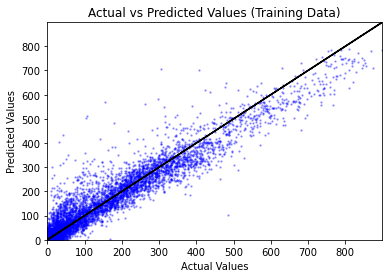

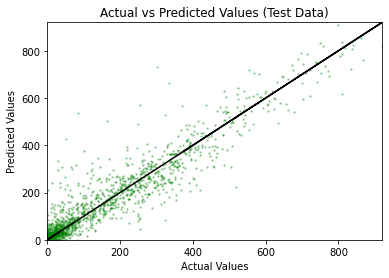

In [40]:
# Use the model to predict the target variable for the training data
predicted_values_train3 = reg3.predict(X_train_poly3)

# Use the model to predict the target variable for the test data
predicted_values_test3 = reg3.predict(X_test_poly3)

# Plot the actual target values against the predicted values for the training data
plt.scatter(y_train, predicted_values_train2, color = "blue", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Training Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_train, y_train, color = "black")
plt.axis([min(y_train), max(y_train), min(y_train), max(y_train)])
plt.show()

# Plot the actual target values against the predicted values for the test data
plt.scatter(y_test, predicted_values_test3, color = "green", s=2, alpha=0.3)
plt.title("Actual vs Predicted Values (Test Data)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot(y_test, y_test, color = "black")
plt.axis([min(y_test), max(y_test), min(y_test), max(y_test)]) 
plt.show()

### Summary with findings

In [29]:
#for range up to 5 it takes too much time
results = []

for degree in range(1, 4):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    reg = LinearRegression(fit_intercept=True).fit(X_train_poly, y_train)
    y_pred = reg.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([degree, mse, mae, r2])

# Create a DataFrame to display the results in a table
results_df = pd.DataFrame(results, columns=["Degree", "MSE", "MAE", "R-squared"])
results_df["MSE"] = results_df["MSE"].apply(lambda x: "{:.5f}".format(x))
results_df["MAE"] = results_df["MAE"].apply(lambda x: "{:.5f}".format(x))
results_df["R-squared"] = results_df["R-squared"].apply(lambda x: "{:.5f}".format(x))
print(results_df)

   Degree                 MSE          MAE        R-squared
0       1          9893.71554     74.51249          0.66988
1       2          3047.17284     37.73939          0.89832
2       3  354824695276.44598  17347.80608  -11839461.03357


## 4.2 Ridge- & Lasso-Regression

To increase the fitting of our Regression, we regularize our models with the Lasso- & Ridge-Regression. We start with the L1-regularization.

In [125]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#### Lasso regression ($L_1$ regularization)



##### Degree=1

In [145]:
model_L1_1 = Lasso(alpha = 0.1)

model_L1_1.fit(X_train_poly, y_train)
predict_1 = model_L1_1.predict(X_train_poly)

print ('The R^2 for linear regression is: ',r2_score(y_train, predict_1))

The R^2 for linear regression is:  0.6660733529465747


As we can see, there is no increase of our R^2 by using the L1-regularization. Therefore we will focus on the polynomial function.

##### Degree=2

In [135]:
model_L1_2 = Lasso(alpha = 0.1)

model_L1_2.fit(X_train_poly2, y_train)
predict = model_L1_2.predict(X_train_poly2)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for quadratic curve is: ',r2_score(y_train, predict))

The R^2 for quadratic curve is:  0.866309073970725


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.922e+06, tolerance: 1.926e+04
  model = cd_fast.enet_coordinate_descent(


As you can see, for a really low penalty term $\alpha$ < 0.01 we can increase the R^2 of our model. An increase in our performance might be possible, but only if we rarely penalise the absolute values of our regression coefficients.

#### Ridge regression ($L_2$ Regularization)

##### Polynomial=2

In [149]:
Poly = PolynomialFeatures(degree = 2)

model_L2_2 = Ridge(alpha = 0.01, normalize = True, solver = 'lsqr')

model_L2_2.fit(X_train_poly2, y_train)
prediction = model_L2_2.predict(X_train_poly2)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for polynomial regression is: ',r2_score(y_train, prediction))

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


The R^2 for polynomial regression is:  0.9016295125692947


As you can see, for a really low penalty term $\alpha$ < 0.01 we can increase the R^2 of our model. 
Overall we can say that an increase of polynomial model (d=2) might be possible, but only if we penalise the sum of the absolute values of the coefficients (L1) or penalise the sum of squares of the model coefficients (L2).

## 4.3 Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [2, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters from the search
best_params = random_search.best_estimator_.get_params()
print("Best parameters found: ",best_params)

Best parameters found:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [19]:
# Use the best parameters to create a new model
best_rf_model = RandomForestRegressor(random_state=42, **random_search.best_params_)

# Fit the new model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the holdout set
y_pred = best_rf_model.predict(X_test)

# Evaluate the new model's performance on the holdout set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

Mean Squared Error:  2147.7500762154123
Mean Absolute Error:  26.23946473968073
R-squared:  0.9283358632489239


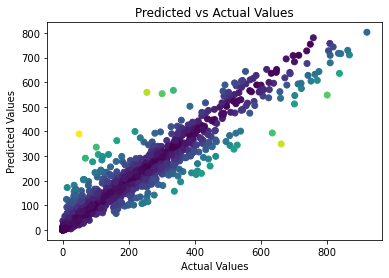

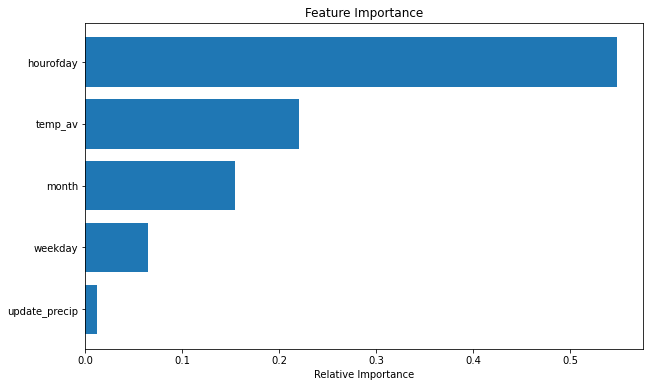

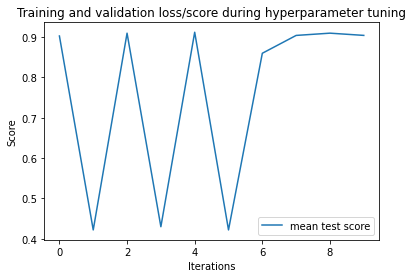

In [20]:
# Create an array of colors based on the difference between the predicted and actual values
colors = np.abs(y_test - y_pred)

# Plot the predicted vs actual values on the holdout set
plt.scatter(y_test, y_pred, c=colors)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Plot the distribution of the feature importances
importances = best_rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

# plot the training and validation loss/score during hyperparameter tuning
plt.plot(random_search.cv_results_['mean_test_score'], label = 'mean test score')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Training and validation loss/score during hyperparameter tuning')
plt.legend()
plt.show()

The metrics indicate that the random forest model is able to predict the number of bike rentals per hour with a relatively high level of accuracy. The Mean Squared Error (MSE) is a measure of how much the model's predictions deviate from the true values, with a lower value indicating a better fit. In this case, the MSE is 2147.75, which suggests that the model's predictions are relatively close to the true values.

The Mean Absolute Error (MAE) is similar to MSE, but it measures the average magnitude of the errors in the model's predictions, without considering their direction. The MAE in this case is 26.23, which suggests that the average magnitude of the errors is relatively low.

The R-squared value is a measure of how much of the variation in the output variable is explained by the model. A value of 1 indicates that the model explains all the variation, while a value of 0 means the model explains none of it. The R-squared value of 0.9283358632489239 indicates that the model explains a large proportion of the variation in the output variable, which is a good indication of model performance.

In summary, the results of the random forest model indicate that the model is able to predict the number of bike rentals per hour with a relatively high level of accuracy, and the MSE, MAE and R-squared values are all good indicators of the model's performance.

## 4.4 Neural Network

First try: The warning message "ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT" is raised because the optimizer used by the neural network (L-BFGS) was not able to find a solution that satisfies the convergence criteria within the maximum number of iterations specified.

Solution: Increase the maximum number of iterations and scale the input features: 'max_iter': [1000, 2000, 5000]

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error:  2909.6630511177023
Mean Absolute Error:  35.0541723838762
R-squared:  0.9029130562703616


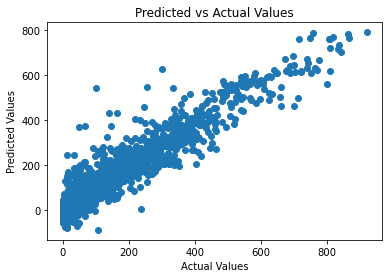

Best parameters found:  {'solver': 'lbfgs', 'max_iter': 2000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'activation': 'relu'}


In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for the MLP model
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (200,)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling'],
    'max_iter': [1000, 2000, 5000]
}

# Create a MLP model
mlp_model = MLPRegressor(random_state=42)

# Use RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(estimator=mlp_model, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Train the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_search.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

# Plot the predicted vs actual values on the test set
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Print the best parameters from the search
best_params = random_search.best_estimator_.get_params()
print("Best parameters found: ",random_search.best_params_)


## 4.5 Gradient Boosting 

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model using the random forest and neural network predictions as input features
X_train_gb = np.column_stack((best_rf_model.predict(X_train), random_search.predict(X_train)))
X_test_gb = np.column_stack((best_rf_model.predict(X_test), random_search.predict(X_test)))

gb_model.fit(X_train_gb, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test_gb)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)


Mean Squared Error:  2725.53845703338
Mean Absolute Error:  32.71461677160589
R-squared:  0.9090567553142218
